# Table of Content:
1. EDA - Original Dataset - 2017 onward <br>
    1.1 Data Acquisition and Exploration <br>
    1.2 Univariate Plots <br>
    1.3 Checking for Homoscedasticity <br>
    1.4 Statsmodels <br>
2. Data Cleaning and Wrangling - 2017 onward <br>
    2.1 [Data Cleaning](#Data-Cleaning) <br>
    2.2 [Feature Engineering](#Feature-Engineering) <br>
    2.3 [Checking for Homoscedasticity](#Checking-for-Homoscedasticity) <br>
    2.4 [HDB Geospatial](#HDB-Geospatial) <br>
3. EDA and Feature Selection - 2017 onward <br>
    3.1 Scatter Plots of Numerical Features <br>
    3.2 Histograms of Numerical Features <br>
    3.3 Histograms and Boxplots of Categorical Features <br>
    3.4 Encoding <br>
    3.5 Correlation Heatmap of Resale Price with All Features <br>
    3.6 Pairwise Correlation <br>
    3.7 Low Variance <br>
    3.8 Recursive Feature Elimination Cross Validation <br>
    3.9 CART and Boosted Feature Importance <br>
    3.10 Permutation Feature Importance <br>
    3.11 Final Feature Selection <br>
4. Model Selection and Tuning - 2017 onward <br>
    4.1 Model Preparation <br>
    4.2 Conclusion <br>
    4.3 Benefits of the model <br>
    4.4 Limitations of the model <br>
    4.5 Future Work <br>
    4.6 Model Improvement <br>
    4.7 Web Application Improvement <br>

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import haversine as hs
from haversine import Unit
from datetime import timedelta
import folium
from folium.plugins import MarkerCluster
from folium import plugins
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# import the hdb dataframe downloaded from https://data.gov.sg/
hdb_df = pd.read_csv('dataset/resale_hdb_price_2017_onward.csv')

## Data Cleaning

In [3]:
# Check the data shape
print('Number of data:',hdb_df.shape[0])
print('This dataframe has',hdb_df.shape[1],'features.')
print('-'*100)

# Check the top 5 of the data
print('Top 5 of the data')
display(hdb_df.head())
print('-'*100)

# Check the data types
print('Key information of the dataset')
print('')
display(hdb_df.info())

Number of data: 82801
This dataframe has 11 features.
----------------------------------------------------------------------------------------------------
Top 5 of the data


month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.0  
4      265000.0

----------------------------------------------------------------------------------------------------
Key information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82801 entries, 0 to 82800
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                82801 non-null  object 
 1   town                 82801 non-null  object 
 2   flat_type            82801 non-null  object 
 3   block                82801 non-null  object 
 4   street_name          82801 non-null  object 
 5   storey_range         82801 non-null  object 
 6   floor_area_sqm       82801 non-null  float64
 7   flat_model           82801 non-null  object 
 8   lease_commence_date  82801 non-null  int64  
 9   remaining_lease      82801 non-null  object 
 10  resale_price         82801 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 6.9+ MB


None

In [4]:
# remove the duplicates dataframe
hdb_df.drop_duplicates(inplace=True)

In [5]:
# reset_index
hdb_df.reset_index(drop=True, inplace=True)

In [6]:
# re-check the shape of the dataframe
print('Number of data:',hdb_df.shape[0])
print('This dataframe has',hdb_df.shape[1],'features.')

Number of data: 82590
This dataframe has 11 features.


In [7]:
# check the dataframe description
hdb_df.describe().T

count           mean            std       min  \
floor_area_sqm       82590.0      97.664686      24.303211      31.0   
lease_commence_date  82590.0    1994.192820      12.888807    1966.0   
resale_price         82590.0  440428.335974  153883.420575  140000.0   

                          25%       50%       75%        max  
floor_area_sqm           82.0      95.0     113.0      249.0  
lease_commence_date    1984.0    1994.0    2003.0     2019.0  
resale_price         330000.0  410000.0  515000.0  1258000.0

In [8]:
# investigating null values
hdb_df.isnull().sum()[hdb_df.isnull().sum() != 0].sort_values(ascending=False)

Series([], dtype: int64)

The dataset is cleaned and no null value.

## Feature Engineering

1. I will modify some of the existing features that can improve the predictability of the machine learning model.

2. Seems like the only 10 default features in the dataset can be use to predict the `resale_price`. I have decided to do more study and research to include different features that can help to predict the HDB flat `resale_price`. 

### Modify existing month feature

I will separate the existing `month` feature in the format of year-month and create 2 new columns for `year` feature and `month` feature.

In [9]:
# create a year column
hdb_df['year'] = pd.DatetimeIndex(hdb_df['month']).year

In [10]:
# update the month column
hdb_df['month'] = pd.DatetimeIndex(hdb_df['month']).month

In [11]:
# Check the top 5 of the data
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  
0      232000.0  2017  
1      250000.0  2017  
2      262000.0  2017  
3      265000.0  2017  
4      265000.0  2017

### Create mean_floor feature using storey_range feature

I will create a new `mean_floor` feature in numerical variable format because it is more predictable compare to the categorical variable.

In [12]:
mean_floor = []

for x in range(0, hdb_df.shape[0]):
    mean_floor.append(int((int(hdb_df['storey_range'][x][:2]) + int(hdb_df['storey_range'][x][-2:]))/2))
    
hdb_df['mean_floor'] = mean_floor

In [13]:
# check the dataframe to ensure the 'mean_floor' column has added and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  
0      232000.0  2017          11  
1      250000.0  2017           2  
2      262000.0  2017           2  
3      265000.0  2017           5  
4      265000.0  2017           2

### Create remaining_year feature using remaining_lease feature

I will retrieve the remaining year data from `remaining_lease` feature in numerical variable format that will be useful for the regression modeling later.

In [14]:
hdb_df['remaining_year'] = hdb_df['remaining_lease'].str.split(' years').str[0].astype(int)

In [15]:
# check the dataframe to ensure the 'bedroom' & 'bathroom 'columns have added
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year  
0      232000.0  2017          11              61  
1      250000.0  2017           2              60  
2      262000.0  2017           2              62  
3      265000.0  2017           5              62  
4      265000.0  2017           2              62

In [16]:
# save to csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated1.csv', index = False)

### New Columns - latitude, longitude

I will scrape the latitude and longitude of each HDB flat from Onemap Singapore website. 

I can use these features to calculate the distance from the HDB flat to the nearest facilities by using haversine formula which I will show it later.

In [17]:
# I notice that the Onemap Singapore unable to study some of the data 'street_name' consist of 'ST' string but not 'ST.'
# so, I have replace the 'ST' with 'Street'
hdb_df['street_name'] = hdb_df['street_name'].str.replace(r'(?:\s|^)ST(?:\s|$)', ' Street ')

In [18]:
# I notice that the Onemap Singapore unable to study some of the data in 'street_name' consist of '.'
# so, I have replace the '.' with black space
hdb_df['street_name'] = hdb_df['street_name'].str.replace('.', '')

In [19]:
hdb_df['street_name'].unique()

array(['ANG MO KIO AVE 10', 'ANG MO KIO AVE 4', 'ANG MO KIO AVE 5',
       'ANG MO KIO AVE 1', 'ANG MO KIO AVE 3', 'ANG MO KIO AVE 9',
       'ANG MO KIO AVE 8', 'ANG MO KIO AVE 6', 'ANG MO KIO Street 52',
       'BEDOK NTH AVE 4', 'BEDOK NTH AVE 1', 'BEDOK NTH RD',
       'BEDOK STH AVE 1', 'BEDOK RESERVOIR RD', 'CHAI CHEE Street ',
       'BEDOK NTH Street 3', 'BEDOK STH RD', 'CHAI CHEE AVE',
       'NEW UPP CHANGI RD', 'CHAI CHEE DR', 'BEDOK STH AVE 2',
       'BEDOK NTH AVE 3', 'BEDOK RESERVOIR VIEW', 'CHAI CHEE RD',
       'LENGKONG TIGA', 'BEDOK CTRL', 'JLN DAMAI', 'BEDOK NTH AVE 2',
       'BEDOK STH AVE 3', 'SIN MING RD', 'SIN MING AVE',
       'BISHAN Street 12', 'BISHAN Street 13', 'BISHAN Street 22',
       'BISHAN Street 24', 'BISHAN Street 23', 'BRIGHT HILL DR',
       'SHUNFU RD', 'BT BATOK Street 34', 'BT BATOK Street 51',
       'BT BATOK Street 11', 'BT BATOK Street 52', 'BT BATOK Street 21',
       'BT BATOK EAST AVE 5', 'BT BATOK WEST AVE 6', 'BT BATOK CTRL',
       

In [20]:
# create 'block_street' to find the latitude and longitude of the hdb blocks
hdb_df['block_street'] = hdb_df['block'] + ' ' + hdb_df['street_name']

In [21]:
# check the dataframe to ensure the 'block_street' column has added and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10  
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4  
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5  
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10  
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5

In [22]:
# play around with the url so that I can familirize with the JSON file
# and find the required information before search for the address data
url = 'https://developers.onemap.sg/commonapi/search?searchVal=' + "330 ANG MO KIO AVE 1" + '&returnGeom=Y&getAddrDetails=Y'

In [23]:
# check the status code to ensure it return 200
header = {'User-agent' : 'Jack Bot 0.1'}
res = requests.get(url, headers = header)
res.status_code

200

In [24]:
json.loads(res.content)

{'found': 1,
 'totalNumPages': 1,
 'pageNum': 1,
 'results': [{'SEARCHVAL': 'TECK GHEE VIEW',
   'BLK_NO': '330',
   'ROAD_NAME': 'ANG MO KIO AVENUE 1',
   'BUILDING': 'TECK GHEE VIEW',
   'ADDRESS': '330 ANG MO KIO AVENUE 1 TECK GHEE VIEW SINGAPORE 560330',
   'POSTAL': '560330',
   'X': '29971.1495055445',
   'Y': '38276.3163302261',
   'LATITUDE': '1.36243186402478',
   'LONGITUDE': '103.851030689651',
   'LONGTITUDE': '103.851030689651'}]}

In [25]:
hdb_data = json.loads(res.content)

In [26]:
hdb_data['results'][0]['LATITUDE']

'1.36243186402478'

In [27]:
hdb_data["results"][0]['LONGITUDE']

'103.851030689651'

In [28]:
# create a function to search for the latitude and longitude of the feature
def lat_long(df, col):
    # df is the dataframe to use
    # col is the column of the dataframe to run this function
    
    lat = []  # empty latitude list
    long = [] # empty longitude list
    header = {'User-agent' : 'Jack Bot 0.1'}

    for i in range(0, df.shape[0]):
        loc = df[col][i]
        url = 'https://developers.onemap.sg/commonapi/search?searchVal=' + loc + '&returnGeom=Y&getAddrDetails=Y'
        res = requests.get(url, headers = header)
                     
        # if status code is not equal to 200, means that It unable to identify the location, this loop will run
        if res.status_code != 200: 
            lat.append('na')
            long.append('na')
            print (f"Unable to identify the location.")
        
        # it will fill up the latitude and longitude of the location
        else:
            data = json.loads(res.content) 
            lat.append(data["results"][0]["LATITUDE"])
            long.append(data["results"][0]["LONGITUDE"])
            print (loc + ", Latitude: "+ data['results'][0]['LATITUDE'] +", Longitude: "+ data['results'][0]['LONGITUDE'])
   
    df['latitude'] = lat   # create new 'latitude' column for the dataframe
    df['longitude'] = long # create new 'longtidue' column for the dataframe

In [29]:
# re-run this code will take ages!!!
# lat_long(hdb_df, 'block_street')

In [30]:
# I have scraped it previously
# So I will read the csv file directly
hdb_df = pd.read_csv('dataset/resale_hdb_price_2017_onward_updated2.csv')

In [31]:
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  
0  1.362005  103.853880  
1  1.370943  103.837975  
2  1.380709  103.835368  
3  1.366201  103.857201  
4  1.381041  103.835132

In [32]:
# check the latitude with 'na' value
hdb_df[hdb_df['latitude'] == 'na']['block_street'].unique()

C:\Users\skfon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([], dtype=object)

In [33]:
# check the longitude with 'na' value
hdb_df[hdb_df['longitude'] == 'na']['block_street'].unique()

array([], dtype=object)

In [34]:
# check the dataframe to make sure 'latitude' and 'longitude' columns have created
# and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  
0  1.362005  103.853880  
1  1.370943  103.837975  
2  1.380709  103.835368  
3  1.366201  103.857201  
4  1.381041  103.835132

In [35]:
# export the new cvs file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated2.csv', index = False)

### New column: dist_to_mrt

This feature will shows the distance of the HDB flat to the nearest rail network in meter. 

I will be using __haversine formula__ to determine the great-circle distance between 2 points on a sphere given their latitude and longitude.

In [36]:
# import the mrt coordinates dataframe
mrt_df = pd.read_csv('dataset/list_of_mrt.csv')

In [37]:
# check the shape of the dataframe
mrt_df.shape

(157, 3)

In [38]:
# show the top 5 of the mrt dataframe list
mrt_df.head()

station_name       lat         lng
0    Jurong East MRT Station  1.333207  103.742308
1    Bukit Batok MRT Station  1.349069  103.749596
2   Bukit Gombak MRT Station  1.359043  103.751863
3  Choa Chu Kang MRT Station  1.385417  103.744316
4        Yew Tee MRT Station  1.397383  103.747523

In [39]:
# check whether any null value
mrt_df.isnull().sum()[mrt_df.isnull().sum() != 0]

Series([], dtype: int64)

In [40]:
mrt_df.describe()

lat         lng
count  157.000000  157.000000
mean     1.345080  103.841362
std      0.044289    0.068544
min      1.265453  103.636866
25%      1.308474  103.790046
50%      1.337649  103.851550
75%      1.384116  103.893133
max      1.449133  103.988487

In [41]:
# check hdb_df data types
hdb_df.dtypes

month                    int64
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
year                     int64
mean_floor               int64
remaining_year           int64
block_street            object
latitude               float64
longitude              float64
dtype: object

In [42]:
# convert 'hdb_lat' and 'hdb_long' to float
hdb_lat = hdb_df['latitude'].astype(float)
hdb_long = hdb_df['longitude'].astype(float)

# create a list of hdb coordinates for distance calculation
list_of_hdb_lat_long = []
for lat, long in zip(hdb_lat, hdb_long):
    list_of_hdb_lat_long.append((lat, long))

In [43]:
# create function to find the distance from hdb to nearest features
def dist_to_hdb(df, col1, col2, new_col):
    # df is the dataframe to use
    # col1 & and col2 is the name of columns to select to convert to float type
    # new_col is the new column to create
    
    # convert the features to float
    fea_lat = df[col1].astype(float)
    fea_long = df[col2].astype(float)
    
    # create list for feature coordinates for calculation of distance
    list_of_fea_lat_long = []
    for lat, long in zip(fea_lat, fea_long):
        list_of_fea_lat_long.append((lat, long))
        
    list_dist = [] # empty list to store all the distance from hdb to feature
    min_dist = [] # store the distance from hdb to the nearest feature

    for x in range(0, len(list_of_hdb_lat_long)): # create each loop for the hdb block
        for y in range(0, len(list_of_fea_lat_long)): # create each loop for the feature

            # calculate every distance in meter from one hdb to every feature and save to the list_dist list
            list_dist.append(hs.haversine(list_of_hdb_lat_long[x], list_of_fea_lat_long[y], unit=Unit.METERS))

        # to find the min value from list_dist list
        nearest_to_fea = (min(list_dist))

        # the min result of nearest_to_mrt1 will store at the min_dist
        min_dist.append(nearest_to_fea)

        # list_hdb_to_mrt1 will be clear and start another loop till the x loop is finished
        list_dist.clear()
        
    # create new distance to feature column, unit is meters
    hdb_df[new_col] = [round(i) for i in min_dist]
    return

In [44]:
# create new 'dist_to_mrt' column, unit is in meter
dist_to_hdb(mrt_df, 'lat', 'lng', 'dist_to_mrt')

In [45]:
# make sure no null value
hdb_df['dist_to_mrt'].isnull().sum()

0

In [46]:
# check the dataframe to make sure 'dist_to_mrt' column has created and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  
0  1.362005  103.853880         1011  
1  1.370943  103.837975         1295  
2  1.380709  103.835368         1069  
3  1.366201  103.857201          947  
4  1.381041  103.835132         1091

In [47]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated3.csv', index = False)

### New column: dist_to_mall

Shopping Malls in Singapore are a one-stop destination for everything (shopping, food, groceries, services). This feature will shows the distance of the HDB flat to the nearest shopping mall in meter. 

I will be using __haversine formula__ to determine the great-circle distance between 2 points on a sphere given their latitude and longitude.

In [48]:
# import mall dataframe
mall_df = pd.read_csv('dataset/list_of_shopping_mall.csv')

In [49]:
# check the shape of mall dataframe
mall_df.shape

(174, 1)

In [50]:
# show the top 5 of the mall dataframe list
mall_df.head()

shopping_mall
0                          100 AM
1                    313@Somerset
2                          Aperia
3  Balestier Hill Shopping Centre
4                      Bugis Cube

In [51]:
# check whether any null value
mall_df.isnull().sum()[mall_df.isnull().sum() != 0]

Series([], dtype: int64)

In [52]:
# remove duplicate if any
mall_df.drop_duplicates(inplace=True)

In [53]:
# re-check the shape of mall dataframe
mall_df.shape

(174, 1)

In [54]:
# check whether any null value
mall_df.isnull().sum()

shopping_mall    0
dtype: int64

In [55]:
# run the function to create latitude and longitude for shopping mall
# lat_long(mall_df, 'shopping_mall')

In [56]:
# I have scraped it previously
# So I will read the csv file directly
mall_df = pd.read_csv('dataset/mall_df_updated.csv')

In [57]:
# check the na value
mall_df[mall_df['latitude'] == 'na']['shopping_mall'].unique()

C:\Users\skfon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([], dtype=object)

In [58]:
# check the na value
mall_df[mall_df['longitude'] == 'na']['shopping_mall'].unique()

array([], dtype=object)

In [59]:
# check the dataframe to make sure 'latitude' and 'longitude' columns have created
# and the information is correct
mall_df.head()

shopping_mall  latitude   longitude
0                          100 AM  1.274588  103.843471
1                    313@Somerset  1.301385  103.837684
2                          Aperia  1.309742  103.864102
3  Balestier Hill Shopping Centre  1.325761  103.843054
4                      Bugis Cube  1.298195  103.855656

In [60]:
# export the dataframe to new csv file
# mall_df.to_csv('dataset/mall_df_updated.csv', index = False)

In [61]:
# create new 'dist_to_mall' column, unit is meters
dist_to_hdb(mall_df, 'latitude', 'longitude', 'dist_to_mall')

In [62]:
# check the dataframe to make sure 'dist_to_mall' column has created and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  
0  1.362005  103.853880         1011          1006  
1  1.370943  103.837975         1295           896  
2  1.380709  103.835368         1069          1530  
3  1.366201  103.857201          947           879  
4  1.381041  103.835132         1091          1574

In [63]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated4.csv', index = False)

### New column: dist_to_hawker

Hawker centres are open-air complexes that house many stalls selling a wide variety of affordably priced food. They are mostly conveniently located at the heart of housing estates, usually with adjourning wet markets. Hawker centres are a unique aspect of Singapore culture and lifestyle.

This feature will shows the distance of the HDB flat to the nearest hawker centre in meter. 

I will be using __haversine formula__ to determine the great-circle distance between 2 points on a sphere given their latitude and longitude.

In [64]:
# import hawker center dataframe
hawker_df = pd.read_csv('dataset/list-of-government-markets-hawker-centres.csv')

In [65]:
# check the shape of the dataframe
hawker_df.shape

(106, 7)

In [66]:
# show the top 5 of the hawker dataframe list
hawker_df.head()

name_of_centre                                 location_of_centre  \
0    Adam Road Food Centre                            2, Adam Road, S(289876)   
1  Amoy Street Food Centre  National Development Building, Annex B, Telok ...   
2        Bedok Food Centre                           1, Bedok Road, S(469572)   
3      Beo Crescent Market                       38A, Beo Crescent, S(169982)   
4       Berseh Food Centre                        166, Jalan Besar, S(208877)   

  type_of_centre       owner  no_of_stalls  no_of_cooked_food_stalls  \
0             HC  Government            32                        32   
1             HC  Government           135                       134   
2             HC  Government            32                        32   
3            MHC  Government            94                        32   
4             HC  Government            66                        66   

   no_of_mkt_produce_stalls  
0                         0  
1                         1  
2                         0  
3                        62  
4                         0

In [67]:
# check the datatype
hawker_df.dtypes

name_of_centre              object
location_of_centre          object
type_of_centre              object
owner                       object
no_of_stalls                 int64
no_of_cooked_food_stalls     int64
no_of_mkt_produce_stalls     int64
dtype: object

In [68]:
# check whether any null value
hawker_df.isnull().sum()[hawker_df.isnull().sum() != 0]

Series([], dtype: int64)

In [69]:
# remove duplicate if any
hawker_df.drop_duplicates(inplace=True)

In [70]:
# use the postal_code to find hawkers latitude and longitude
hawker_df['postal_code'] = hawker_df['location_of_centre'].str.split('(').str[-1].str.replace(')','')

In [71]:
# check the 'postal_code'
hawker_df['postal_code'].unique()

array(['289876', '069111', '469572', '169982', '208877', '588215',
       '557269', '149644', '424768', '468960', '402001', '199583',
       '277700', '397972', '048940', '069184', '229495', '198783',
       '118543', '555945', '574419', '618499', '148813', '168898',
       '247792', '150006', '180270', '150120', '161001', '530105',
       '090011', '160112', '151115', '380117', '310127', '521137',
       '140159', '460016', '150163', '380017', '270020', '462208',
       '310210', '460216', '310022', '564226', '568226', '600254',
       '330029', '570320', '560341', '600347', '120353', '090036',
       '601037', '560409', '270044', '120448', '561453', '380049',
       '402004', '432004', '120502', '120503', '640505', '441050',
       '390051', '460511', '560527', '460538', '461058', '081006',
       '560628', '470630', '330069', '260007', '560724', '120726',
       '310074', '310075', '150079', '100079', '370080', '100082',
       '440084', '460085', '150085', '370089', '320090', '3100

In [72]:
# discover that some data that have more than 1 postal code
# split and only keep 1 of the postal code
hawker_df.loc[hawker_df['postal_code'].str.contains('/'), 'postal_code'] = hawker_df['postal_code'].str.split('/').str[0]

In [73]:
# check the 'postal_code'
hawker_df['postal_code'].unique()

array(['289876', '069111', '469572', '169982', '208877', '588215',
       '557269', '149644', '424768', '468960', '402001', '199583',
       '277700', '397972', '048940', '069184', '229495', '198783',
       '118543', '555945', '574419', '618499', '148813', '168898',
       '247792', '150006', '180270', '150120', '161001', '530105',
       '090011', '160112', '151115', '380117', '310127', '521137',
       '140159', '460016', '150163', '380017', '270020', '462208',
       '310210', '460216', '310022', '564226', '568226', '600254',
       '330029', '570320', '560341', '600347', '120353', '090036',
       '601037', '560409', '270044', '120448', '561453', '380049',
       '402004', '432004', '120502', '120503', '640505', '441050',
       '390051', '460511', '560527', '460538', '461058', '081006',
       '560628', '470630', '330069', '260007', '560724', '120726',
       '310074', '310075', '150079', '100079', '370080', '100082',
       '440084', '460085', '150085', '370089', '320090', '3100

In [74]:
# run the function to create latitude and longitude for shopping mall
# lat_long(hawker_df, 'postal_code')

In [75]:
# I have scraped it previously
# So I will read the csv file directly
hawker_df = pd.read_csv('dataset/hawker_df_updated.csv')

In [76]:
# check the na value
hawker_df[hawker_df['latitude'] == 'na']['name_of_centre'].unique()

C:\Users\skfon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([], dtype=object)

In [77]:
# check the na value
hawker_df[hawker_df['longitude'] == 'na']['name_of_centre'].unique()

array([], dtype=object)

In [78]:
# check the dataframe to make sure 'latitude' and 'longitude' columns have created
# and the information is correct
hawker_df.head()

name_of_centre                                 location_of_centre  \
0    Adam Road Food Centre                            2, Adam Road, S(289876)   
1  Amoy Street Food Centre  National Development Building, Annex B, Telok ...   
2        Bedok Food Centre                           1, Bedok Road, S(469572)   
3      Beo Crescent Market                       38A, Beo Crescent, S(169982)   
4       Berseh Food Centre                        166, Jalan Besar, S(208877)   

  type_of_centre       owner  no_of_stalls  no_of_cooked_food_stalls  \
0             HC  Government            32                        32   
1             HC  Government           135                       134   
2             HC  Government            32                        32   
3            MHC  Government            94                        32   
4             HC  Government            66                        66   

   no_of_mkt_produce_stalls  postal_code  latitude   longitude  
0                         0       289876  1.324160  103.814166  
1                         1        69111  1.279218  103.846607  
2                         0       469572  1.320354  103.955472  
3                        62       169982  1.288840  103.827401  
4                         0       208877  1.307337  103.856854

In [79]:
# check the data types
hawker_df.dtypes

name_of_centre               object
location_of_centre           object
type_of_centre               object
owner                        object
no_of_stalls                  int64
no_of_cooked_food_stalls      int64
no_of_mkt_produce_stalls      int64
postal_code                   int64
latitude                    float64
longitude                   float64
dtype: object

In [80]:
# export the dataframe to new csv file
# hawker_df.to_csv('dataset/hawker_df_updated.csv', index = False)

In [81]:
# create new 'dist_to_hawker' column, unit is meters
dist_to_hdb(hawker_df, 'latitude', 'longitude', 'dist_to_hawker')

In [82]:
# check the dataframe to make sure 'dist_to_hawker' column has created and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  dist_to_hawker  
0  1.362005  103.853880         1011          1006             182  
1  1.370943  103.837975         1295           896             418  
2  1.380709  103.835368         1069          1530             592  
3  1.366201  103.857201          947           879             242  
4  1.381041  103.835132         1091          1574             617

In [83]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated5.csv', index = False)

### New column: dist_to_child_centre

Most parents in Singapore are working and they would not able to take care of their children during their working hours. So, they will be depending on the childcare centres, preschool or kindergarten to look after their children while they are working. So, it is important to have the centres around the HDB area.

This feature will shows the distance of the HDB flat to the nearest child centre in meter. 

I will be using __haversine formula__ to determine the great-circle distance between 2 points on a sphere given their latitude and longitude.

In [84]:
# import child center dataframe
child_centre_df = pd.read_csv('dataset/child_centres.csv')

In [85]:
# check the shape of the dataframe
child_centre_df.shape

(1923, 29)

In [86]:
# show the top 5 of the child center dataframe list
child_centre_df.head()

tp_code centre_code                                centre_name  \
0      na      PT8575                  DNC (EDUCATION) PTE. LTD.   
1      na      PT4520            TOTS TOWN PRESCHOOL @ SEMBAWANG   
2      na      PT9440  Sunflower Preschool @ Sembawang Pte. Ltd.   
3      na      PT8690                   LORNA WHISTON PRE-SCHOOL   
4      na      PT6560                   LORNA WHISTON PRE-SCHOOL   

  organisation_code organisation_description service_model centre_contact_no  \
0                PT        Private Operators            CC          64400859   
1                PT        Private Operators            CC          67532422   
2                PT        Private Operators            CC          64816388   
3                PT        Private Operators            CC          68718748   
4                PT        Private Operators            CC          68718782   

              centre_email_address  \
0               whatsup@mrskoh.com   
1                 info@totstown.sg   
2          sfk.sembawang@gmail.com   
3  kallangwave@lornawhiston.com.sg   
4   winchester@lornawhiston.com.sg   

                                      centre_address  postal_code  \
0        11,TANJONG KATONG ROAD,#03-19,ONE KM,437157       437157   
1                 480,SEMBAWANG DRIVE,#01-455,750480       750480   
2  534,SEMBAWANG ROAD,SEMBAWANG SPRINGS ESTATE,75...       758407   
3    1,STADIUM PLACE,#01-24,KALLANG WAVE MALL,397628       397628   
4                          09,WINCHESTER ROAD,117783       117783   

         centre_website infant_vacancy pg_vacancy     n1_vacancy  \
0                    na             na         na             na   
1                    na             na  Immediate      Immediate   
2  www.sunflowerkid.com             na  Immediate      Immediate   
3  www.lornawhiston.com             na  Immediate  Within 1 Year   
4  www.lornawhiston.com             na         na             na   

      n2_vacancy k1_vacancy k2_vacancy  \
0             na         na         na   
1      Immediate  Immediate  Immediate   
2      Immediate  Immediate  Immediate   
3  Within 1 Year  Immediate  Immediate   
4             na         na         na   

                                        food_offered second_languages_offered  \
0  Halal Food With No Beef (with Certification fr...                  Chinese   
1                                                 na                       na   
2  No Pork No Lard with No Beef (without Certific...                  Chinese   
3  No Pork No Lard with No Beef (from Non-Halal S...                  Chinese   
4  No Pork No Lard with No Beef (without Certific...                  Chinese   

  spark_certified weekday_full_day     saturday scheme_type  \
0              No      07:00-19:00           na          na   
1              No      07:00-19:00           na          na   
2              No      07:00-19:00  07:00-14:00          na   
3              No      07:00-19:00  07:00-14:00          na   
4              No      07:00-19:00  07:00-14:00          na   

  extended_operating_hours provision_of_transport government_subsidy  \
0                       No                    Yes                Yes   
1                       No                     No                Yes   
2                       No                    Yes                Yes   
3                       No                     No                Yes   
4                       No                    Yes                Yes   

  gst_regisration last_updated remarks  
0             Yes   2020-12-13      na  
1              No   2020-12-13      na  
2              No   2020-12-12      na  
3             Yes   2020-12-12      na  
4             Yes   2020-12-12      na

In [87]:
# check the datatype
child_centre_df.dtypes

tp_code                     object
centre_code                 object
centre_name                 object
organisation_code           object
organisation_description    object
service_model               object
centre_contact_no           object
centre_email_address        object
centre_address              object
postal_code                  int64
centre_website              object
infant_vacancy              object
pg_vacancy                  object
n1_vacancy                  object
n2_vacancy                  object
k1_vacancy                  object
k2_vacancy                  object
food_offered                object
second_languages_offered    object
spark_certified             object
weekday_full_day            object
saturday                    object
scheme_type                 object
extended_operating_hours    object
provision_of_transport      object
government_subsidy          object
gst_regisration             object
last_updated                object
remarks             

In [88]:
# check whether any null value
# since I will only use the 'postal_code' feature, so I will ignore other features
child_centre_df.isnull().sum()[child_centre_df.isnull().sum() != 0]

centre_website    2
dtype: int64

In [89]:
# remove duplicate if any
child_centre_df.drop_duplicates(inplace=True)

In [90]:
child_centre_df['postal_code'] = child_centre_df['postal_code'].astype(str)

In [91]:
for count, item in enumerate(child_centre_df['postal_code']):
    if len(item) == 5:
        child_centre_df['postal_code'][count] = '0' + item
    else:
        child_centre_df['postal_code'][count] = child_centre_df['postal_code'][count]

In [92]:
# run the function to create latitude and longitude for shopping mall
# lat_long(child_centre_df, 'postal_code')

In [93]:
# I have scraped it previously
# So I will read the csv file directly
child_centre_df = pd.read_csv('dataset/child_centre_df_updated.csv')

In [94]:
# check the na value
child_centre_df[child_centre_df['latitude'] == 'na']['postal_code'].unique()

C:\Users\skfon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([], dtype=int64)

In [95]:
# check the na value
child_centre_df[child_centre_df['longitude'] == 'na']['postal_code'].unique()

array([], dtype=int64)

In [96]:
# check the dataframe to make sure 'latitude' and 'longitude' columns have created
# and the information is correct
child_centre_df.head()

tp_code centre_code                                centre_name  \
0      na      PT8575                  DNC (EDUCATION) PTE. LTD.   
1      na      PT4520            TOTS TOWN PRESCHOOL @ SEMBAWANG   
2      na      PT9440  Sunflower Preschool @ Sembawang Pte. Ltd.   
3      na      PT8690                   LORNA WHISTON PRE-SCHOOL   
4      na      PT6560                   LORNA WHISTON PRE-SCHOOL   

  organisation_code organisation_description service_model centre_contact_no  \
0                PT        Private Operators            CC          64400859   
1                PT        Private Operators            CC          67532422   
2                PT        Private Operators            CC          64816388   
3                PT        Private Operators            CC          68718748   
4                PT        Private Operators            CC          68718782   

              centre_email_address  \
0               whatsup@mrskoh.com   
1                 info@totstown.sg   
2          sfk.sembawang@gmail.com   
3  kallangwave@lornawhiston.com.sg   
4   winchester@lornawhiston.com.sg   

                                      centre_address  postal_code  \
0        11,TANJONG KATONG ROAD,#03-19,ONE KM,437157       437157   
1                 480,SEMBAWANG DRIVE,#01-455,750480       750480   
2  534,SEMBAWANG ROAD,SEMBAWANG SPRINGS ESTATE,75...       758407   
3    1,STADIUM PLACE,#01-24,KALLANG WAVE MALL,397628       397628   
4                          09,WINCHESTER ROAD,117783       117783   

         centre_website infant_vacancy pg_vacancy     n1_vacancy  \
0                    na             na         na             na   
1                    na             na  Immediate      Immediate   
2  www.sunflowerkid.com             na  Immediate      Immediate   
3  www.lornawhiston.com             na  Immediate  Within 1 Year   
4  www.lornawhiston.com             na         na             na   

      n2_vacancy k1_vacancy k2_vacancy  \
0             na         na         na   
1      Immediate  Immediate  Immediate   
2      Immediate  Immediate  Immediate   
3  Within 1 Year  Immediate  Immediate   
4             na         na         na   

                                        food_offered second_languages_offered  \
0  Halal Food With No Beef (with Certification fr...                  Chinese   
1                                                 na                       na   
2  No Pork No Lard with No Beef (without Certific...                  Chinese   
3  No Pork No Lard with No Beef (from Non-Halal S...                  Chinese   
4  No Pork No Lard with No Beef (without Certific...                  Chinese   

  spark_certified weekday_full_day     saturday scheme_type  \
0              No      07:00-19:00           na          na   
1              No      07:00-19:00           na          na   
2              No      07:00-19:00  07:00-14:00          na   
3              No      07:00-19:00  07:00-14:00          na   
4              No      07:00-19:00  07:00-14:00          na   

  extended_operating_hours provision_of_transport government_subsidy  \
0                       No                    Yes                Yes   
1                       No                     No                Yes   
2                       No                    Yes                Yes   
3                       No                     No                Yes   
4                       No                    Yes                Yes   

  gst_regisration last_updated remarks  latitude   longitude  
0             Yes   2020-12-13      na  1.314692  103.894481  
1              No   2020-12-13      na  1.452202  103.815169  
2              No   2020-12-12      na  1.437031  103.825927  
3             Yes   2020-12-12      na  1.303843  103.872751  
4             Yes   2020-12-12      na  1.285696  103.794394

In [97]:
# check the data types
child_centre_df.dtypes

tp_code                      object
centre_code                  object
centre_name                  object
organisation_code            object
organisation_description     object
service_model                object
centre_contact_no            object
centre_email_address         object
centre_address               object
postal_code                   int64
centre_website               object
infant_vacancy               object
pg_vacancy                   object
n1_vacancy                   object
n2_vacancy                   object
k1_vacancy                   object
k2_vacancy                   object
food_offered                 object
second_languages_offered     object
spark_certified              object
weekday_full_day             object
saturday                     object
scheme_type                  object
extended_operating_hours     object
provision_of_transport       object
government_subsidy           object
gst_regisration              object
last_updated                

In [98]:
# export the dataframe to new csv file
# child_centre_df.to_csv('dataset/child_centre_df_updated.csv', index = False)

In [99]:
# create new 'dist_to_child_centre' column, unit is meters
dist_to_hdb(child_centre_df, 'latitude', 'longitude', 'dist_to_child_centre')

In [100]:
# check the dataframe to make sure 'dist_to_child_centre' column has created and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  dist_to_hawker  \
0  1.362005  103.853880         1011          1006             182   
1  1.370943  103.837975         1295           896             418   
2  1.380709  103.835368         1069          1530             592   
3  1.366201  103.857201          947           879             242   
4  1.381041  103.835132         1091          1574             617   

   dist_to_child_centre  
0                   273  
1                    99  
2                    45  
3                    45  
4                     0

In [101]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated6.csv', index = False)

### New Columns - bedroom, bathroom

I have add the number of bedroom and bathroom features as well. This information can get from the [HDB](https://www.hdb.gov.sg/residential/buying-a-flat/resale/getting-started/types-of-flats) website.

In [102]:
# create a loop to generate the list of the bedroom and bathroom
bedroom = []
bathroom = []

for ite, val in enumerate(hdb_df['flat_type']):
        if hdb_df['flat_type'][ite] == '1 ROOM':
            bedroom.append(0)
            bathroom.append(1)
        elif hdb_df['flat_type'][ite] == '2 ROOM':
            bedroom.append(1)
            bathroom.append(1)
        elif hdb_df['flat_type'][ite] == '3 ROOM':
            bedroom.append(2)
            bathroom.append(2)
        elif hdb_df['flat_type'][ite] == '4 ROOM':
            bedroom.append(3)
            bathroom.append(2)
        elif hdb_df['flat_type'][ite] == '5 ROOM':
            bedroom.append(3)
            bathroom.append(2)
        elif hdb_df['flat_type'][ite] == 'MULTI-GENERATION':
            bedroom.append(4)
            bathroom.append(3)
        else:
            bedroom.append(3)
            bathroom.append(2)
            
# input the list into dataframe
hdb_df['bedroom'] = bedroom
hdb_df['bathroom'] = bathroom

In [103]:
# check the dataframe to ensure the 'bedroom' & 'bathroom 'columns have added
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  dist_to_hawker  \
0  1.362005  103.853880         1011          1006             182   
1  1.370943  103.837975         1295           896             418   
2  1.380709  103.835368         1069          1530             592   
3  1.366201  103.857201          947           879             242   
4  1.381041  103.835132         1091          1574             617   

   dist_to_child_centre  bedroom  bathroom  
0                   273        1         1  
1                    99        2         2  
2                    45        2         2  
3                    45        2         2  
4                     0        2         2

In [104]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated7.csv', index = False)

### New column: dist_to_city

Turn out the HDB flat that are closer to the city seem to be more expensive.

This feature will shows the distance of the HDB flat to Singapore city center in meter.

I will be using haversine formula to determine the great-circle distance between 2 points on a sphere given their latitude and longitude.

In [105]:
list_dist = [] # empty list to store all the distance from hdb to feature
city_coordinates = [1.287953, 103.851784] # Singapore Downtown Core latitude and longitude

for x in range(0, len(list_of_hdb_lat_long)): # create each loop for the hdb block
    # calculate every distance in meter from one hdb to every feature and save to the list_dist list
    list_dist.append(hs.haversine(list_of_hdb_lat_long[x], city_coordinates, unit=Unit.METERS))

# create new distance to feature column, unit is meters
hdb_df['dist_to_city'] = [round(i) for i in list_dist]

In [106]:
# check the dataframe to make sure 'dist_to_city' column has created and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  dist_to_hawker  \
0  1.362005  103.853880         1011          1006             182   
1  1.370943  103.837975         1295           896             418   
2  1.380709  103.835368         1069          1530             592   
3  1.366201  103.857201          947           879             242   
4  1.381041  103.835132         1091          1574             617   

   dist_to_child_centre  bedroom  bathroom  dist_to_city  
0                   273        1         1          8237  
1                    99        2         2          9355  
2                    45        2         2         10474  
3                    45        2         2          8722  
4                     0        2         2         10515

In [107]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated8.csv', index = False)

### New column: dist_to_pri_sch

In Singapore, in order to get into the top primary school, parents who are Singapore Citizens (SC) will be given priority over Singapore Permanent Residents (PR). SCs who live within 1 kilometre (km) of the school will be given priority, followed by those who live between 1 km and 2 km from the school and lastly, for those who live more than 2 km from the school.

Only when there are leftover places will PRs who live less than 1 km etc from the school be allocated a place for their child. If there are not enough vacancies, balloting will be conducted. Most parents in Singapore willing to get a HDB near the top primary school in order to get their children to get into the top school.

For primary school dataframe, I will using the top 20 primary school ranking in Singapore in 2020.

This feature will shows the distance of the HDB flat to the nearest top 20 primary school in meter.

I will be using haversine formula to determine the great-circle distance between 2 points on a sphere given their latitude and longitude.

In [108]:
# import primary school dataframe
pri_sch_df = pd.read_csv('dataset/primary_school.csv')

In [109]:
# check the shape of the dataframe
pri_sch_df.shape

(20, 1)

In [110]:
pri_sch_df.head()

primary_school
0                        Rosyth School
1       CHIJ St Nicholas Girls' School
2  Pei Hwa Presbyterian Primary School
3                       Ai Tong School
4               Nan Hua Primary School

In [111]:
# run the function to create latitude and longitude for top 20 primary school
# lat_long(pri_sch_df, 'primary_school')

In [112]:
# export the dataframe to new csv file
# pri_sch_df.to_csv('dataset/primary_school_updated.csv', index = False)

In [113]:
# I have scraped it previously
# So I will read the csv file directly
pri_sch_df = pd.read_csv('dataset/primary_school_updated.csv')

In [114]:
# check the dataframe to make sure 'latitude' and 'longitude' columns have created
# and the information is correct
pri_sch_df.head()

primary_school  latitude   longitude
0                        Rosyth School  1.372916  103.874693
1       CHIJ St Nicholas Girls' School  1.373730  103.834309
2  Pei Hwa Presbyterian Primary School  1.338067  103.776191
3                       Ai Tong School  1.360736  103.833076
4               Nan Hua Primary School  1.319837  103.761404

In [115]:
# check the na value
pri_sch_df[pri_sch_df['latitude'] == 'na']['primary_school'].unique()

C:\Users\skfon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([], dtype=object)

In [116]:
# check the na value
pri_sch_df[pri_sch_df['longitude'] == 'na']['primary_school'].unique()

array([], dtype=object)

In [117]:
# create new 'dist_to_child_centre' column, unit is meters
dist_to_hdb(pri_sch_df, 'latitude', 'longitude', 'dist_to_pri_sch')

In [118]:
# check the dataframe to make sure 'dist_to_pri_sch' column has created and the information is correct
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  dist_to_hawker  \
0  1.362005  103.853880         1011          1006             182   
1  1.370943  103.837975         1295           896             418   
2  1.380709  103.835368         1069          1530             592   
3  1.366201  103.857201          947           879             242   
4  1.381041  103.835132         1091          1574             617   

   dist_to_child_centre  bedroom  bathroom  dist_to_city  dist_to_pri_sch  
0                   273        1         1          8237             1368  
1                    99        2         2          9355              512  
2                    45        2         2         10474              785  
3                    45        2         2          8722             1952  
4                     0        2         2         10515              818

In [119]:
# export the dataframe to new csv file
# hdb_df.to_csv('dataset/resale_hdb_price_2017_onward_updated9.csv', index = False)

## Checking for Homoscedasticity

Homoscedasticity describes a situation in which the error or random disturbance in the relationship between the independent variables and the dependent variable is the same across all values of the independent variables

In [120]:
hdb_df = pd.read_csv('dataset/resale_hdb_price_2017_onward_updated9.csv')

In [121]:
hdb_df.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  mean_floor  remaining_year           block_street  \
0      232000.0  2017          11              61  406 ANG MO KIO AVE 10   
1      250000.0  2017           2              60   108 ANG MO KIO AVE 4   
2      262000.0  2017           2              62   602 ANG MO KIO AVE 5   
3      265000.0  2017           5              62  465 ANG MO KIO AVE 10   
4      265000.0  2017           2              62   601 ANG MO KIO AVE 5   

   latitude   longitude  dist_to_mrt  dist_to_mall  dist_to_hawker  \
0  1.362005  103.853880         1011          1006             182   
1  1.370943  103.837975         1295           896             418   
2  1.380709  103.835368         1069          1530             592   
3  1.366201  103.857201          947           879             242   
4  1.381041  103.835132         1091          1574             617   

   dist_to_child_centre  bedroom  bathroom  dist_to_city  dist_to_pri_sch  
0                   273        1         1          8237             1368  
1                    99        2         2          9355              512  
2                    45        2         2         10474              785  
3                    45        2         2          8722             1952  
4                     0        2         2         10515              818

In [122]:
# the following features will be drop because the information are used to find the other features
# the task has completed so the features can be removed
hdb_df = hdb_df.drop(columns = ['remaining_lease', 'block_street', 'latitude', 'longitude'])

In [123]:
hdb_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'year', 'mean_floor', 'remaining_year', 'dist_to_mrt', 'dist_to_mall',
       'dist_to_hawker', 'dist_to_child_centre', 'bedroom', 'bathroom',
       'dist_to_city', 'dist_to_pri_sch'],
      dtype='object')

In [124]:
# one hot encoding for all object data
hdb_df = pd.get_dummies(data=hdb_df, drop_first=True)

In [125]:
hdb_df.shape

(82590, 3220)

There are 3220 number of features of one hot encoding which is a lot. I will fit all the feature into baseline model, linear regression model to check the result of R2 and RMSE.

In [126]:
# Creation of baseline linear model
X = hdb_df.drop(columns=['resale_price'])
y = hdb_df['resale_price']

In [127]:
# standardizing the input data
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [128]:
# fit Linear Regression into X_sc and y 
lr = LinearRegression()
lr.fit(X_sc, y)
y_pred = lr.predict(X_sc)

In [129]:
# Our baseline model can explain 94.54% of the variance in sale price. Our baseline model also has an RSME around 36,000.
print('R2:', round(lr.score(X_sc, y), 4))
print('RMSE:', round(np.sqrt(mean_squared_error(y, y_pred)), 2))

R2: 0.9454
RMSE: 35959.4


The R-squared value is 0.9454, which means that 94.46% of the variation in the target variable (resale_price) is explained by the independent variables. 

The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data â€“ how close the observed data points are to the target variable (resale_price). Lower values of RMSE indicate better fit. Linear Regression has RMSE of around 36,000.

When I compare to the original dataset (R-squared value :0.9446, RMSE: 36176), the updated dataset has a slightly better result but not difference. Maybe it will show better result when I use different regression machine learning model.

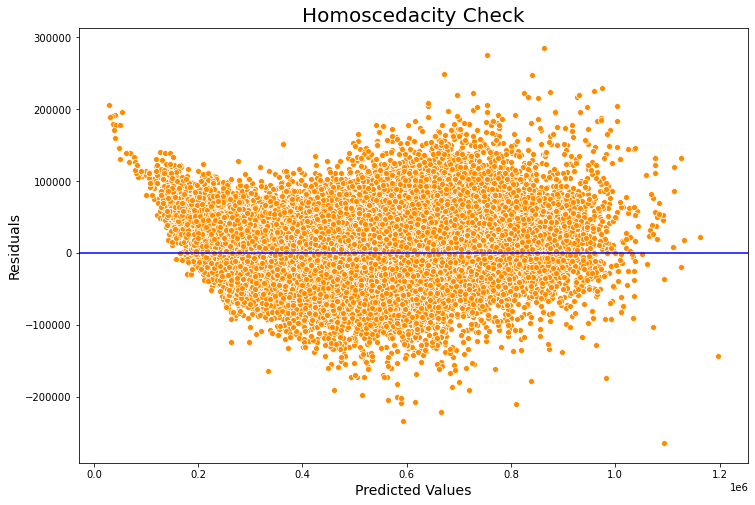

In [130]:
# Plotting residuals
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=X, x=y_pred, y=y-y_pred, color= 'darkorange')
ax.axhline(y=0, c='blue')
plt.title('Homoscedacity Check', fontsize=20)
plt.ylabel('Residuals', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14);

Residual plot shows that errors are Heteroscedasticity. Residuals are more sparsely distributed as price increase.

Let's fit the linear regression model predicted values to the actual values to check their relationship.

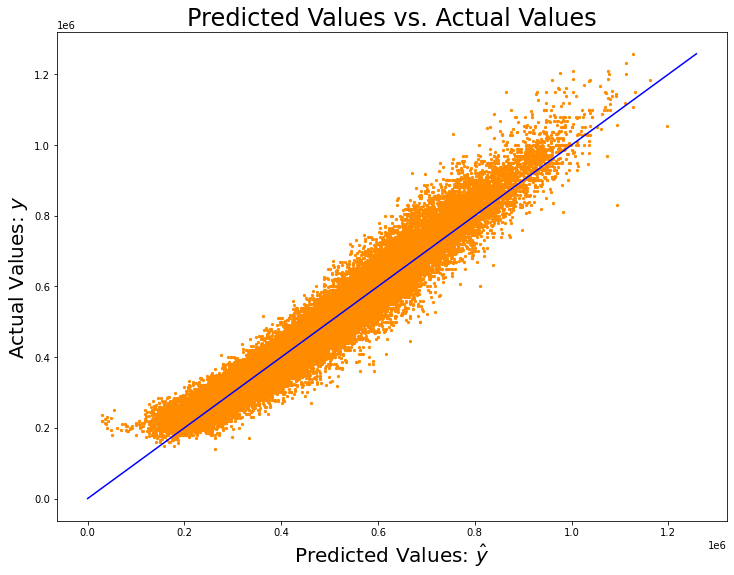

In [131]:
# Plot the model
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y, s=5, color='darkorange')

# Plot a line.
plt.plot([0, np.max(y)],
         [0, np.max(y)],
         color = 'blue')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

Majority of the points are fill around the diagonal line and some of them are away from the diagonal line, this means that on average our residuals are reasonable small which is a good fit.

## HDB Geospatial

Folium is a Python library used for visualizing geospatial data. It is easy to use and yet a powerful library. Folium is a Python wrapper for Leaflet. js which is a leading open-source JavaScript library for plotting interactive maps. It has the power of Leaflet

In [135]:
hdb_df = pd.read_csv('dataset/resale_hdb_price_2017_onward_updated9.csv')
mrt_df = pd.read_csv('dataset/list_of_mrt.csv')
mall_df = pd.read_csv('dataset/mall_df_updated.csv')
hawker_df = pd.read_csv('dataset/hawker_df_updated.csv')
child_centre_df = pd.read_csv('dataset/child_centre_df_updated.csv')
pri_sch_df = pd.read_csv('dataset/primary_school_updated.csv')

In [2]:
'''Long = 103.851784
Lat = 1.287953
sgmap = folium.Map([Lat, Long], zoom_start=11)
sgmap_hdb = plugins.MarkerCluster().add_to(sgmap)

for lat, lon, label1, label2 in zip(hdb_df.latitude,hdb_df.longitude,hdb_df.block_street, hdb_df.resale_price):
    folium.Marker(location=[lat,lon],icon=folium.Icon(icon='home'),
                  popup=str(label1) + ' $' + str(label2)).add_to(sgmap_hdb)

for lat_mrt, lon_mrt, label_mrt in zip(mrt_df.lat,mrt_df.lng,mrt_df.station_name):
    folium.Marker(location=[lat_mrt,lon_mrt],icon=folium.Icon(icon='train', prefix='fa'),
                  popup=str(label_mrt)).add_to(sgmap_hdb)
    
for lat_mall, lon_mall, label_mall in zip(mall_df.latitude,mall_df.longitude,mall_df.shopping_mall):
    folium.Marker(location=[lat_mall,lon_mall],icon=folium.Icon(icon='shopping-cart', color='orange', prefix='fa'),
                  popup=str(label_mall)).add_to(sgmap_hdb)

for lat_hawker, lon_hawker, label_hawker in zip(hawker_df.latitude,hawker_df.longitude,hawker_df.name_of_centre):
    folium.Marker(location=[lat_hawker,lon_hawker],icon=folium.Icon(icon='cutlery', color='lightgreen', prefix='fa'),
                  popup=str(label_hawker)).add_to(sgmap_hdb)
    
for lat_child_centre, lon_child_centre, label_child_centre in zip(child_centre_df.latitude,child_centre_df.longitude,child_centre_df.centre_name):
    folium.Marker(location=[lat_child_centre,lon_child_centre],icon=folium.Icon(icon='child', color='lightred', prefix='fa'),
                  popup=str(label_child_centre)).add_to(sgmap_hdb)    
    
for lat_pri_sch, lon_pri_sch, label_pri_sch in zip(pri_sch_df.latitude,pri_sch_df.longitude,pri_sch_df.primary_school):
    folium.Marker(location=[lat_pri_sch,lon_pri_sch],icon=folium.Icon(icon='graduation-cap', color='darkred', prefix='fa'),
                  popup=str(label_pri_sch)).add_to(sgmap_hdb)    

sgmap.add_child(sgmap_hdb)

sgmap.save("sgmap.html")

sgmap''';

I want to get a better visual of what's the data telling us geographically. 

This map will show us the location of the HDB flats sold in each town. When you zoom into the map, you will see the details of the HDB flat and various facilities that I have added.